# OC PROJET 5 - AUTOMATICALLY CATEGORIZE QUESTIONS
#### CLEANING AND ANALYSIS NOTEBOOK
<br></br>
### SOMMAIRE
- <a href="#C1">I. Nettoyage des données</a>
    
- <a href="#C2">II. Feature Engineering</a>

- <a href="#C3">III. Preprocessing</a>
    
- <a href="#C4">IV. Exploration des données</a>
    - 1. Matrice des corrélations
    - 2. Analyse temporelle
    - 3. Analyse Quanti/Quanti
    - 4. Analyse Quanti/Quali
    - 5. Analyse Quali/Quali
    - 6. ACP

# <a name="C1">I. Nettoyage et fusion des données</a>

<font size="5">1. Importation des librairies</font>

In [51]:
# importation des librairies
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import font_manager as rcParams
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import enchant
from sklearn import metrics

<font size="5">2. Paramétrages Data Visualisation</font>

In [2]:
# Ajouter une ombre à la police
shadow = path_effects.withSimplePatchShadow(offset = (1, - 0.75), 
shadow_rgbFace = 'darkblue', alpha = 0.25)

# changer la police dans les graphiques, les couleurs 
# et augmenter la résolution d'affichage
plt.rcParams['font.family'] = 'Ebrima'
plt.rcParams['text.color'] = 'white'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.style.use('dark_background')

# set le theme seaborn
sns.set_style('darkgrid', {'axes.facecolor': '0.2',
'text.color': 'white', 'figure.figsize': (20, 16)})
plt.rcParams['figure.facecolor'] = '0.2'

# suppression de l'affichage max des colonnes
pd.set_option('display.max_columns', None)

<font size="5">3. Requêtes SQL</font>

SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, AnswerCount, CreationDate, LastActivityDate, CommentCount
FROM Posts
WHERE PostTypeId = 1 
  AND ViewCount > 100 
  AND Score > 3 
  AND AnswerCount > 0 
  AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5 
  AND CommentCount > 0
ORDER BY Id ASC

SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, AnswerCount, CreationDate, LastActivityDate, CommentCount
FROM Posts
WHERE PostTypeId = 1 
  AND ViewCount > 100 
  AND Score > 3 
  AND AnswerCount > 0 
  AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5 
  AND CommentCount > 0
ORDER BY Id DESC

<font size="5">4. Dataframe</font>

In [3]:
df1 = pd.read_csv('QueryResultsAsc.csv')
df2 = pd.read_csv('QueryResultsDesc.csv')

In [4]:
# Fusion des DataFrames df1 et df2 sur la colonne commune
df = pd.concat([df1, df2])
df.shape

(100000, 10)

In [5]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount
0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,<c#><floating-point><type-conversion><double><...,4,795,72107,13,2008-07-31 21:42:52,2022-09-08 05:07:26,4
1,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,11,1645,198982,41,2008-07-31 23:55:37,2022-09-05 11:26:30,3
2,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,13,704,285740,27,2008-08-01 00:42:38,2022-03-29 07:31:31,10
3,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,19,351,68134,23,2008-08-01 05:21:22,2023-03-27 07:55:50,17
4,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,25,175,15977,9,2008-08-01 12:13:50,2023-06-01 11:20:00,1


In [6]:
df.isnull().sum()

Title               0
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
AnswerCount         0
CreationDate        0
LastActivityDate    0
CommentCount        0
dtype: int64

In [7]:
df.loc[df.duplicated(keep = False),:]

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount


In [8]:
df.dtypes

Title               object
Body                object
Tags                object
Id                   int64
Score                int64
ViewCount            int64
AnswerCount          int64
CreationDate        object
LastActivityDate    object
CommentCount         int64
dtype: object

In [9]:
df.describe()

,Id,Score,ViewCount,AnswerCount,CommentCount
count,1.000000e+05,100000.000000,1.000000e+05,100000.000000,100000.00000
mean,3.140196e+07,24.862830,2.314290e+04,3.326830,3.57137
std,2.647337e+07,172.320926,1.223877e+05,3.746832,3.23915
min,4.000000e+00,4.000000,1.010000e+02,1.000000,1.00000
25%,5.628995e+06,5.000000,1.734000e+03,1.000000,1.00000
50%,2.863875e+07,7.000000,4.754000e+03,2.000000,3.00000
75%,5.611157e+07,13.000000,1.338200e+04,4.000000,5.00000
max,7.639181e+07,25651.000000,1.278321e+07,134.000000,51.00000


In [11]:
def preprocess_text(text):
    # Supprimer les balises HTML
    text = re.sub('<.*?>', '', text)
    
    # Convertir en minuscules
    text = text.lower()
    
    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Supprimer les mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoindre les tokens prétraités en une seule chaîne de texte
    processed_text = ' '.join(tokens)
    
    return processed_text

In [12]:
df['body_preprocess'] = df['Body'].apply(preprocess_text)

In [13]:
pd.set_option('display.max_colwidth', None)
df['body_preprocess'].head(10)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# !!!

In [23]:
def remove_nonexistent_words(text):
    words = text.split()
    english_dict = enchant.Dict("en_US")

    valid_words = []
    for word in words:
        if english_dict.check(word):
            valid_words.append(word)

    return ' '.join(valid_words)

In [24]:
df['body_cleanax'] = df['body_preprocess'].apply(remove_nonexistent_words)

AttributeError: module 'enchant' has no attribute 'Dict'

In [29]:
import nltk
from nltk.corpus import words

def nettoyer_texte(texte):
    mots_valides = set(words.words())

    mots = nltk.word_tokenize(texte)
    mots_nettoyes = [mot for mot in mots if mot.lower() in mots_valides]
    texte_nettoye = ' '.join(mots_nettoyes)

    return texte_nettoye

texte = 'want assign decimal variable quottransquot double variable quotthisopacityquot decimal trans trackbar1value 5000 thisopacity trans build app give following error cannot implicitly convert type decimal double'
texte_nettoye = nettoyer_texte(texte)
print(texte_nettoye)

want assign decimal variable double variable decimal build give following error can not implicitly convert type decimal double


In [30]:
df['body_cleanax'] = df['body_preprocess'].apply(nettoyer_texte)

In [31]:
df['body_cleanax']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  want assign decimal variable double variable decimal build give following error can not implicitly convert type decimal double
1                                                                                                                                                                     

In [40]:
# sauvegarde du dataframe
df.to_csv('QueryResultsClean.csv', index = False)

In [45]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    model = KMeans(n_clusters = k).fit(X)
    inertia.append(model.inertia_)

C:\Users\Oliver\AppData\Local\Temp\ipykernel_4460\804946866.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K_range, inertia, 'bx-', color = 'springgreen')


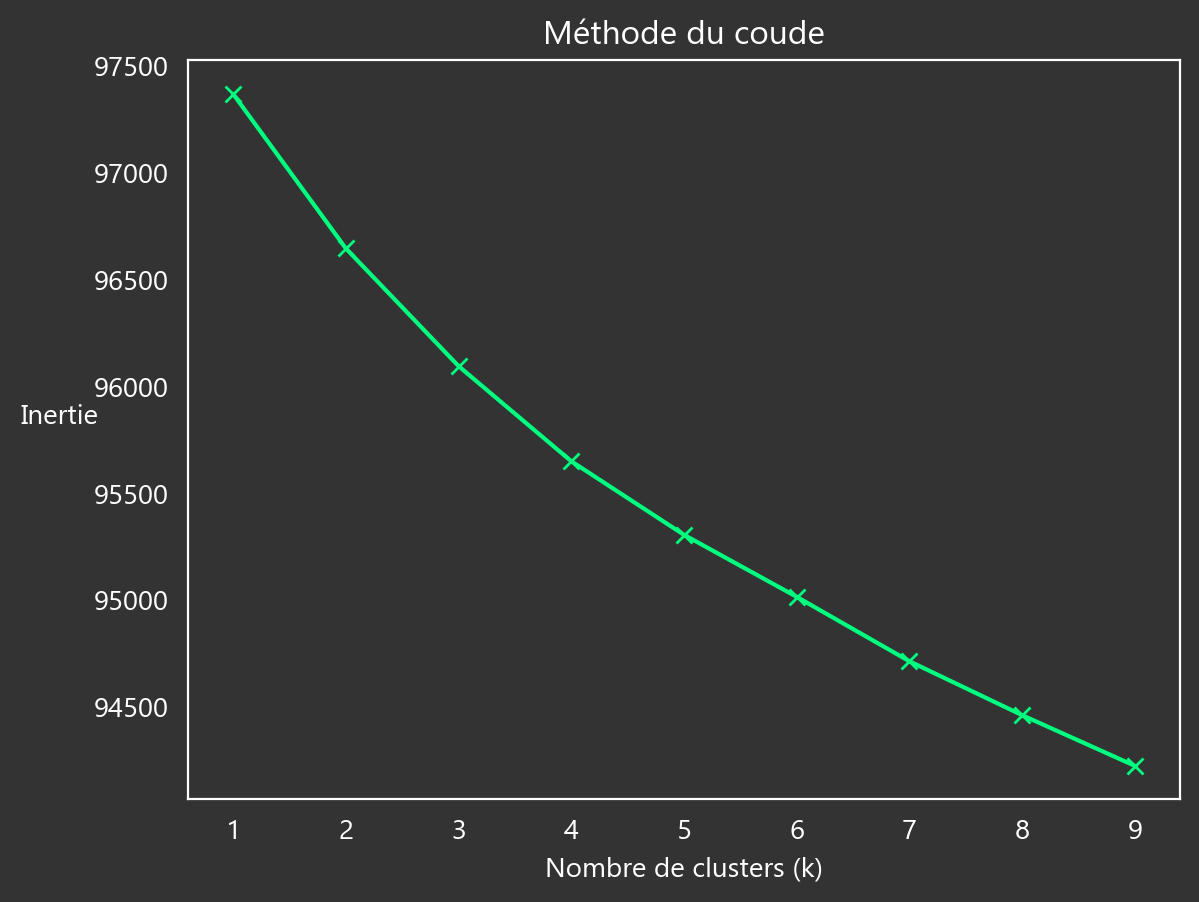

In [47]:
plt.rcParams['font.family'] = 'Ebrima'
plt.plot(K_range, inertia, 'bx-', color = 'springgreen')
plt.xlabel('Nombre de clusters (k)', color = 'white')
plt.gca().yaxis.set_label_coords( - 0.13, 0.5)
plt.ylabel('Inertie', rotation = 360, color = 'white')
plt.title('Méthode du coude')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(False)
plt.show()

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Extraction des fonctionnalités avec TF-IDF
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["Body"])

# Application de l'algorithme de clustering (K-means)
num_clusters = 5  # Nombre de clusters souhaité
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Affichage des mots clés pour chaque cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster", i)
    for ind in order_centroids[i, :10]:  # Afficher les 10 mots clés les plus représentatifs
        print(terms[ind])
    print()
    
# Dans cette dernière partie, nous récupérons les indices 
# des centres de cluster triés dans l'ordre décroissant 
# en termes de proximité avec les mots clés. 
# Ensuite, nous récupérons les mots clés à partir du TfidfVectorizer. 
# Ensuite, nous itérons sur chaque cluster et affichons 
# les 10 mots clés les plus représentatifs pour chaque cluster.

Cluster 0
import
error
component
export
react
return
file
class
module
code

Cluster 1
file
line
error
directory
code
folder
like
use
want
new

Cluster 2
like
code
function
use
want
data
way
value
return
work

Cluster 3
public
class
private
new
void
string
return
static
method
null

Cluster 4
error
run
server
project
version
build
application
file
test
install



C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Cluster 0:
Ce cluster est centré sur les mots liés à l'importation de modules, aux erreurs, aux composants et à l'exportation dans le contexte du développement avec React. Les mots "import", "error", "component", "export", "react", "return", "file", "class", "module" et "code" suggèrent que les utilisateurs posent des questions sur l'importation de modules, la gestion des erreurs, les composants React, l'exportation de fonctionnalités, les fichiers et les classes dans le développement avec React.

Cluster 1:
Ce cluster est associé à des mots clés liés aux fichiers, aux lignes de code et à la gestion des erreurs. Les mots "file", "line", "error", "directory", "code", "folder", "like", "use", "want" et "new" indiquent que les utilisateurs posent des questions sur la gestion des fichiers, la localisation d'erreurs, la navigation dans les répertoires, l'utilisation de codes et la création de nouveaux éléments.

Cluster 2:
Ce cluster est axé sur les mots liés à l'utilisation des codes et des fonctions. Les mots "like", "code", "function", "use", "want", "data", "way", "value", "return" et "work" suggèrent que les utilisateurs posent des questions sur l'utilisation de codes, les fonctions, la manipulation des données et la résolution de problèmes.

Cluster 3:
Ce cluster est associé à des mots clés liés à la programmation orientée objet. Les mots "public", "class", "private", "new", "void", "string", "return", "static", "method" et "null" indiquent que les utilisateurs posent des questions sur les concepts de classes, d'objets, de méthodes et de variables dans la programmation orientée objet.

Cluster 4:
Ce cluster est centré sur les mots liés à l'exécution de projets, aux erreurs, aux versions et à l'installation d'applications. Les mots "error", "run", "server", "project", "version", "build", "application", "file", "test" et "install" suggèrent que les utilisateurs posent des questions sur l'exécution de projets, la gestion des erreurs, les versions de logiciels, la construction d'applications, les tests et l'installation de programmes.

In [44]:
# Extraction des fonctionnalités avec TF-IDF
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["Body"])

# Application de l'algorithme de clustering (K-means)
num_clusters = 4  # Nombre de clusters souhaité
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Affichage des mots clés pour chaque cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster", i)
    for ind in order_centroids[i, :10]:  # Afficher les 10 mots clés les plus représentatifs
        print(terms[ind])
    print()

Cluster 0
like
code
use
function
want
data
way
return
value
work

Cluster 1
import
error
file
return
component
export
react
module
class
code

Cluster 2
file
error
project
run
build
line
version
install
command
code

Cluster 3
public
class
new
private
void
string
return
static
method
null



C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Cluster 0:
Ce cluster est axé sur les mots liés à la manipulation du code et des fonctions. Les mots "like", "code", "use", "function", "want", "data", "way", "return", "value" et "work" suggèrent que les utilisateurs posent des questions sur l'utilisation de fonctions, la manipulation des données et la recherche de solutions de travail.

Cluster 1:
Ce cluster est lié à l'importation, aux erreurs et à la manipulation de fichiers dans le contexte du développement de logiciels. Les mots "import", "error", "file", "return", "component", "export", "react", "module" et "class" indiquent que les utilisateurs posent des questions sur l'importation de modules, la gestion des erreurs et la manipulation des fichiers dans le cadre du développement avec React.

Cluster 2:
Ce cluster est centré sur les mots liés aux erreurs, aux projets et à l'exécution de commandes. Les mots "file", "error", "project", "run", "build", "line", "version", "install" et "command" suggèrent que les utilisateurs posent des questions sur la gestion des erreurs, l'exécution de projets, la construction de programmes et l'installation de logiciels.

Cluster 3:
Ce cluster est associé à des mots clés liés à la programmation orientée objet. Les mots "public", "class", "new", "private", "void", "string", "return", "static", "method" et "null" indiquent que les utilisateurs posent des questions sur les concepts de classes, d'objets, de méthodes et de variables dans la programmation orientée objet.

In [54]:
kmeans_labels = kmeans.labels_
# Évaluer les performances du modèle K-means
silhouette_score = metrics.silhouette_score(X.toarray(), kmeans_labels)
calinski_harabasz_score = metrics.calinski_harabasz_score(X.toarray(), kmeans_labels)
davies_bouldin_score = metrics.davies_bouldin_score(X.toarray(), kmeans_labels)

In [55]:
print("Scores K-means :")
print("Silhouette score :", silhouette_score)
print("Calinski-Harabasz score :", calinski_harabasz_score)
print("Davies-Bouldin score :", davies_bouldin_score)

Scores K-means :
Silhouette score : 0.0035867528631406825
Calinski-Harabasz score : 599.4805359501959
Davies-Bouldin score : 7.799644634682886


In [58]:
from sklearn.feature_extraction.text import CountVectorizer

# Liste de questions
questions = df['Body']

# Initialisation du vectoriseur bag-of-words
vectorizer = CountVectorizer()

# Construction de la matrice de termes-document
X = vectorizer.fit_transform(questions)

# Application de l'algorithme K-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

# Récupération des mots les plus fréquents dans chaque cluster
n_words = 10
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(3):
    print(f"Cluster {i+1} mots clés :")
    for j in range(n_words):
        print(f"- {terms[order_centroids[i, j]]}")
    print()

# Suggestions de tags basées sur les mots clés fréquents dans chaque cluster
suggested_tags = []
for i in range(3):
    tags = [terms[order_centroids[i, j]] for j in range(n_words)]
    suggested_tags.append(tags)

print("Suggestions de tags :")
for i, tags in enumerate(suggested_tags):
    print(f"Cluster {i+1} : {tags}")

Cluster 1 mots clés :
- public
- class
- new
- return
- private
- string
- void
- get
- null
- set

Cluster 2 mots clés :
- builder
- step
- version
- python
- file
- line
- requirement
- warning
- parse
- starting

Cluster 3 mots clés :
- code
- like
- use
- get
- error
- file
- would
- return
- new
- work

Suggestions de tags :
Cluster 1 : ['public', 'class', 'new', 'return', 'private', 'string', 'void', 'get', 'null', 'set']
Cluster 2 : ['builder', 'step', 'version', 'python', 'file', 'line', 'requirement', 'warning', 'parse', 'starting']
Cluster 3 : ['code', 'like', 'use', 'get', 'error', 'file', 'would', 'return', 'new', 'work']


C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
for i in range(4):
    print(f"Cluster {i+1} mots clés :")
    for j in range(n_words):
        print(f"- {terms[order_centroids[i, j]]}")
    print()

# Suggestions de tags basées sur les mots clés fréquents dans chaque cluster
suggested_tags = []
for i in range(4):
    tags = [terms[order_centroids[i, j]] for j in range(n_words)]
    suggested_tags.append(tags)

print("Suggestions de tags :")
for i, tags in enumerate(suggested_tags):
    print(f"Cluster {i+1} : {tags}")

Cluster 1 mots clés :
- public
- class
- new
- return
- private
- string
- void
- get
- null
- set

Cluster 2 mots clés :
- builder
- step
- version
- python
- file
- line
- requirement
- warning
- parse
- starting

Cluster 3 mots clés :
- code
- like
- use
- get
- error
- file
- would
- return
- new
- work

Cluster 4 mots clés :
- file
- error
- import
- line
- return
- code
- function
- get
- data
- run

Suggestions de tags :
Cluster 1 : ['public', 'class', 'new', 'return', 'private', 'string', 'void', 'get', 'null', 'set']
Cluster 2 : ['builder', 'step', 'version', 'python', 'file', 'line', 'requirement', 'warning', 'parse', 'starting']
Cluster 3 : ['code', 'like', 'use', 'get', 'error', 'file', 'would', 'return', 'new', 'work']
Cluster 4 : ['file', 'error', 'import', 'line', 'return', 'code', 'function', 'get', 'data', 'run']


In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

data = df

# Extraction des tags uniques
all_tags = set()
for tags_list in data['Tags']:
    tags = tags_list.strip('<>').split('><')
    all_tags.update(tags)

# Création de la liste des tags
tags = list(all_tags)
num_tags = len(tags)

# Mapping des tags aux indices
tag_to_index = {tag: index for index, tag in enumerate(tags)}

# Division des données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Chargement du modèle BERT pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Encodage des données en utilisant BERT
train_input = tokenizer.batch_encode_plus(
    train_data['Title'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
test_input = tokenizer.batch_encode_plus(
    test_data['Title'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Extraction des embeddings des questions avec BERT
train_embeddings = bert_model.predict(train_input['input_ids'])
test_embeddings = bert_model.predict(test_input['input_ids'])

# Préparation des étiquettes
train_labels = np.zeros((len(train_data), num_tags))
test_labels = np.zeros((len(test_data), num_tags))

for i, tags_list in enumerate(train_data['Tags']):
    tags = tags_list.strip('<>').split('><')
    for tag in tags:
        train_labels[i, tag_to_index[tag]] = 1

for i, tags_list in enumerate(test_data['Tags']):
    tags = tags_list.strip('<>').split('><')
    for tag in tags:
        test_labels[i, tag_to_index[tag]] = 1

# Création du modèle de classification basé sur un réseau neuronal
input_layer = Input(shape=(train_embeddings.shape[1],))
output_layer = Dense(num_tags, activation='sigmoid')(input_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam')

# Entraînement du modèle
model.fit(
    train_embeddings,
    train_labels,
    batch_size=32,
    epochs=10,
    validation_data=(test_embeddings, test_labels)
)

# Évaluation du modèle
predictions = model.predict(test_embeddings)
predicted_labels = (predictions > 0.5).astype(int)
report = classification_report(test_labels, predicted_labels, target_names=tags)
print(report)

ModuleNotFoundError: No module named 'tensorflow'